In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import random 
import math
import numpy as np

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)

In [4]:
# build the dataset
random.shuffle(words)
block_size = 8 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1

X, Y = torch.tensor(X), torch.tensor(Y)

In [5]:
# data set splits 80%, 10%, 10%
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

In [9]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5 #kaimin init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.runnig_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True) # batch mean
            x_var = x.var(dim, keepdim=True) # batch variance 
        else:
            x_mean = self.running_mean
            x_var = self.runnig_var
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # normalize 
        self.out = self.gamma * x_hat + self.beta 
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * x_mean
                self.runnig_var = (1-self.momentum) * self.runnig_var + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weights = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, inx):
        self.out = self.weights[inx]
        return self.out
    
    def parameters(self):
        return [self.weights]
    
class FlattenConsecutive:
    def __init__(self, n) -> None:
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]


n_embd = 10 # dim of the character embedding vector
n_hidden = 200 # the # of neurons in the hidden layer
g = torch.Generator().manual_seed(42)

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(2*n_embd, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    #last layer: make less confindent
    model.layers[-1].weights *= 0.1

parameters = model.parameters()
for param in parameters:
    param.requires_grad_(True)
sum(p.numel() for p in parameters)

171497

In [7]:
torch.manual_seed(42); # seed rng for reproducibility

In [10]:
# train
inxs = []
losses = []
batch_size = 64
steps = 1_000_00
for i in range(steps):
    # minibatch construct
    inx = torch.randint(0, training_set.shape[0], (batch_size,))
    Xb, Yb = training_set[inx], y_training_set[inx]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    l_r = 0.1 if i < 250_000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    # if i % 1000 == 0: # print every once in a while
    #     print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(i)

loss.item() # best loss 2.14

1.7500102519989014

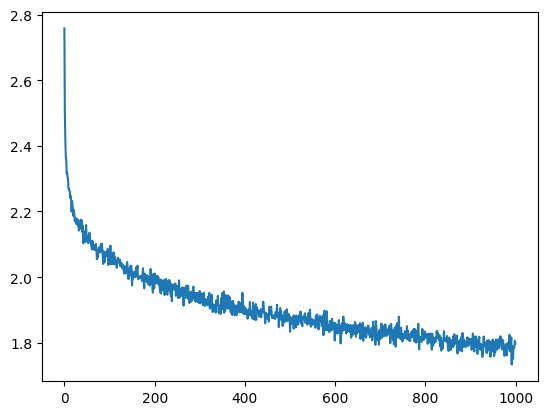

In [11]:
plt.plot(torch.tensor(losses).view(-1, 100).mean(dim=1));

In [12]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [13]:
@torch.no_grad() # disable gradient tracking
def get_loss(data_set):
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(data_set, loss.item())

get_loss('train')
get_loss('dev')

train 1.7794479131698608
dev 2.06990909576416


In [15]:
# sample from the model

for _ in range(20):
    
	out = '.' * block_size
	print(out)
	while True:
		print([str_to_inx[x] for x in out[-block_size:]])
		logits = model(torch.tensor([str_to_inx[x] for x in out[-block_size:]]))
		probs = F.softmax(logits, dim=1)
		inx = torch.multinomial(probs, num_samples=1).item()
		out = out + inx_to_str[inx]
		if inx == 0:
			break
    
	print(out.replace('.', ''))

........
[0, 0, 0, 0, 0, 0, 0, 0]


ValueError: not enough values to unpack (expected 3, got 2)